<a href="https://colab.research.google.com/github/linjiw/787/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q1: One-vs-All (OVA) Logistic Regression for Handwritten Digits

preprocess colab and data files.

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/24787/hw4

/content/drive/MyDrive/24787/hw4


In [5]:
%ls

digits.mat  MLAI24787_hw04_2022Spring.pdf  train.txt  w.npy
hw4.ipynb   test.txt                       w_all.npy  w_sk.npy


##(a) Load data

In [6]:
data = sio.loadmat("digits.mat")

x = data['X']
y = np.squeeze(data['y']).reshape((-1,1))

np.place(y,y==10,0) #replace 10 with 0 in labels 
numExamples = x.shape[0] 
numFeaturs = x.shape[1] 
numLabels = 10 #10 class

In [7]:
print(f"numExamples {numExamples} numFeaturs {numFeaturs} numLabels {numLabels} y.shape {y.shape}")

numExamples 5000 numFeaturs 400 numLabels 10 y.shape (5000, 1)


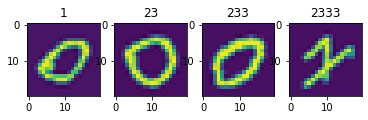

In [18]:
range1 = [0,22,232,2332]
fig, axs = plt.subplots(1, 4)
# axs[0, 0].plot(x, y)
# axs[1, 1].scatter(x, y)

for idx, i in enumerate(range1):
  pic = x[i,:].reshape((20,20))
  axs[idx].imshow(pic)
  axs[idx].set_title(f"{i+1}")
plt.show()


##(b)(Training the OVA classifier with gradient descent)

In [13]:
def sigmoid(z):

  return 1 / (1 + np.exp(-z))

def cost(theta, X, y):

  predictions = sigmoid(X @ theta) 
  predictions[predictions == 1] = 0.999 #log(1)=0 causes error in division 
  error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
  return sum(error) / len(y);

def costGradient(theta, X, y):

  predictions = sigmoid(X @ theta)
  # print(f"predictions.shape {predictions.shape} X.shape {X.shape} X.T @ predictions")
  return X.transpose() @ (predictions - y) / len(y)

define splitdata function: split data to train and test

In [15]:
def splitdata(x,y):
  train_x = np.empty((0,numFeaturs))
  train_y = np.empty((0,1))
  val_x = np.empty((0,numFeaturs))
  val_y = np.empty((0,1))
  for i in range(10):
    train_x = np.vstack((train_x,x[i*500:(i+1)*500-100,:]))
    train_y = np.vstack((train_y,y[i*500:(i+1)*500-100,:]))
    val_x = np.vstack((val_x,x[i*500+400:(i+1)*500,:]))
    # print(val_x.shape)
    val_y = np.vstack((val_y,y[i*500+400:(i+1)*500,:]))
  return train_x,train_y,val_x,val_y

train_x,train_y,val_x,val_y = splitdata(x,y)
print(f"train_x {train_x.shape} train_y {train_y.shape} val_x {val_x.shape} val_y {val_y.shape}")

train_x (4000, 400) train_y (4000, 1) val_x (1000, 400) val_y (1000, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

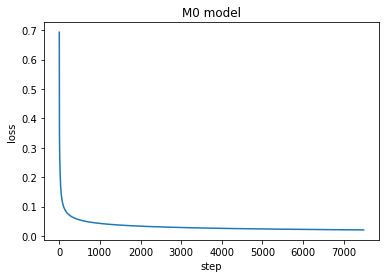

 50%|█████     | 5/10 [05:26<05:37, 67.54s/it]

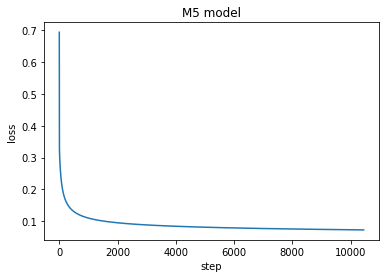

100%|██████████| 10/10 [12:01<00:00, 72.11s/it]


In [16]:
def plotloss(losslst,id=None):
    plt.plot(np.arange(len(losslst)), losslst)
    plt.title(f"M{id} model")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.show()

def train(X,Y,class_idx,step=0.1,iter=1e6,threshold=1e-6,e=1e-8,ifplot = False,id=None):
    X = np.hstack((X,np.ones((X.shape[0],1))))
    Z = np.zeros((Y.shape))
    Z[Y==class_idx] = 1
    Z[Y!=class_idx] = 0
    error  = 1e5
    count = 0
    prev = 0
    J_lst = []
    # w = np.array([[-65],[0],[0]],dtype=float)
    theta = np.zeros((numFeaturs+1,1))
    while error > threshold and count<iter:

        J = cost(theta,X,Z)
        G = costGradient(theta,X,Z)
        # print(f"G.shape {G.shape}. theta.shape {theta.shape}")
        theta -= step*G
        error = np.abs(J-prev)
        prev = J
        J_lst.append(J)
        count+=1
        # print(f"loss {J}")
    if ifplot:
      plotloss(J_lst,id=id)
    
    return theta

# W = np.zeros((numFeaturs,1))
w_all = np.empty((numFeaturs+1,0))

for i in tqdm(range(10)):
  if i==0 or i==5:
    # w_all[str(i)] = train(train_x,train_y,i,ifplot=True)
    w_all = np.hstack((w_all,train(train_x,train_y,i,ifplot=True,id=i)))
  else:
    w_all = np.hstack((w_all,train(train_x,train_y,i,ifplot=False)))
  # w_sk = 
np.save('w_all.npy',w_all)





prediction

In [ ]:
# w_mat = np.empty((numFeaturs+1,0))
# for i in range(10):
#   w_mat = np.hstack((w_mat,w_all[str(i)]))
# print(w_mat.shape)

(401, 10)


generate prediction for the $[1,23,233,2333]$ images.

In [17]:

def predict(x,w_mat):
  predictions = np.empty((numExamples,0))
  x = np.hstack((x,np.ones((x.shape[0],1))))
  for i in range(10):
    # theta = w_all[str(i)]
    prob = sigmoid(x @ w_mat[:,i]).reshape((-1,1))
    
    predictions = np.hstack((predictions,prob))

  pred = np.argmax(predictions,axis=1).reshape((-1,1))
  return pred

pred = predict(x,w_all)

for i in range1:
  print(f" {i+1}: {pred[i]}\n ")



 1: [0]
 
 23: [0]
 
 233: [0]
 
 2333: [4]
 


calculate accuracy for my trained model.



In [20]:
def pred_acc(x,y,w_mat):
  x = np.hstack((x,np.ones((x.shape[0],1))))
  predictions = sigmoid(x @ w_mat)
  pred = np.argmax(predictions,axis=1).reshape((-1,1))
  # print(pred)
  acc = sum(pred==y)/len(y)
  # print(acc)
  # print("acc: {:.2f}%".format(acc))
  return acc[0]
train_acc = pred_acc(train_x,train_y,w_all)
test_acc = pred_acc(val_x,val_y,w_all)
whole_acc = pred_acc(x,y,w_all)
print("train acc: {:.2f}%".format(train_acc*100))
print("test acc: {:.2f}%".format(test_acc*100))
# print("whole acc: {:.2f}%".format(whole_acc*100))





train acc: 93.23%
test acc: 90.10%


calculate accuracy using sklearn.

In [23]:
from sklearn import linear_model 

# pad_train_x = 
def sk_train(X,Y,class_idx):
    X = np.hstack((X,np.ones((X.shape[0],1))))
    Z = Y.copy()
    Z[Y==class_idx] = 1
    Z[Y!=class_idx] = 0
    # print(Z) 
    clf = linear_model.LogisticRegression(penalty="l2", solver="liblinear",tol=1e-6,max_iter=int(1e6))
    clf.fit(X,Z.ravel())
    w = clf.coef_.reshape(-1,1)
    # score = clf.score(X,Z)
    # print(score)
    return w

w_sk = np.empty((numFeaturs+1,0))
for i in range(10):
  # print(i)
  w_sk = np.hstack((w_sk,sk_train(x,y,i)))
np.save('w_sk.npy',w_sk) 

In [24]:
# w_sk = w_sk.reshape((-1,1))
train_acc = pred_acc(train_x,train_y,w_sk)
test_acc = pred_acc(val_x,val_y,w_sk)
whole_acc = pred_acc(x,y,w_sk)
print("train acc: {:.2f}%".format(train_acc*100))
print("test acc: {:.2f}%".format(test_acc*100))
# print("whole acc: {:.2f}%".format(whole_acc*100))

train acc: 91.90%
test acc: 91.90%


Here we could notice that the accuracy of my model is very similar to the accuracy of using sklearn linear model. Thus, my model could be verified useful.

##Q2 : Data Normalization and Error

In [25]:
test_data = np.loadtxt("test.txt")
train_data = np.loadtxt("train.txt")
print(f"test_data {test_data.shape} train_data {train_data.shape}")

test_data (500, 3) train_data (1000, 3)


In [ ]:
# test_data = np.hstack((test_data, np.ones((test_data.shape[0],1))) )
# train_data = np.hstack((train_data, np.ones((train_data.shape[0],1))) )

In [26]:
def splitdata(data):
  x = data[:,:2]
  y = data[:,-1]
  return x,y

In [27]:
train_x, train_y = splitdata(train_data)
test_x, test_y = splitdata(test_data)

use map_feature method to map input to a cubic function.

In [28]:
def map_feature(X,feature_num=3):
  x1 = X[:,0].reshape(-1,1)
  x2 = X[:,1].reshape(-1,1)
  # feature_lst = []
  count = 0
  feature_lst = None
  for j in range(feature_num+1):
    for k in range(j+1):
      if count ==0:
        feature_lst = (x1**(k))*(x2**(j-k))
      else:
        feature_lst= np.hstack((feature_lst,(x1**(k))*(x2**(j-k))))
      count +=1
  print(feature_lst.shape)
  return feature_lst

In [29]:
train_X_cubic = map_feature(train_x)
test_X_cubic = map_feature(test_x)
# print(train_X_cubic)

(1000, 10)
(500, 10)


##(a)  no-standardization, output the vector of eigenvalues of the $A^TA$ matrix

In [30]:
eig, _ = np.linalg.eig(train_X_cubic.T @ train_X_cubic)
ratio = max(eig) / min(eig)
print(f"eig {eig}")
print(f"ratio {ratio}")

eig [0.00000000e+00 3.69838267e+27 2.55647952e+20 1.84299854e+17
 2.39035796e+13 7.29695889e+09 1.18665615e+07 2.25891639e+06
 4.41363216e+04 4.45802681e+02]
ratio inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Here we could notice that since the min eigenvalue is 0, thus the ratio between the largest and the smallest is infinity. Since the min eigenvalue is 0, thus the ratio is inf and connot be computed.

##(b)  no-standardization, output your model’s prediction

In [31]:
w = np.linalg.inv(train_X_cubic.T @ train_X_cubic) @ train_X_cubic.T @ train_y.reshape((-1,1))
print(f"w {w.shape}")

w (10, 1)


In [33]:
pred = test_X_cubic @ w
print(f"prediction: \n{pred}")


prediction: 
[[  45.8471992 ]
 [  50.55510689]
 [   9.47781858]
 [  23.6217668 ]
 [ -20.19232482]
 [  49.60034064]
 [ 119.99144615]
 [  17.39498882]
 [ 124.87883503]
 [  87.62907357]
 [ 120.2144563 ]
 [ 116.57534971]
 [  53.9979086 ]
 [  -2.5993566 ]
 [  61.82501499]
 [  59.98939643]
 [ -23.8638442 ]
 [  45.76169736]
 [  41.46209512]
 [  94.03043272]
 [  72.35192523]
 [  69.09409629]
 [  61.37915435]
 [   5.68083576]
 [  60.15787873]
 [  66.68030435]
 [  13.10122171]
 [ -19.62814556]
 [  12.21877149]
 [  59.93585168]
 [ 118.84117681]
 [  23.84810988]
 [  40.52951869]
 [  43.79447959]
 [  63.30032389]
 [  18.62917909]
 [ -10.6919105 ]
 [  68.98636304]
 [   5.65599235]
 [  54.66243217]
 [  10.83823185]
 [  26.31228688]
 [  -7.72989688]
 [  30.71087477]
 [  19.3359053 ]
 [  38.49654709]
 [ 111.2475721 ]
 [ -14.12426607]
 [ 100.44747038]
 [  24.77493139]
 [  89.6150683 ]
 [  -5.17743765]
 [ -12.75180698]
 [  41.69450721]
 [   2.92541669]
 [  -1.56792993]
 [  30.83157587]
 [ 105.84753935]
 

##(c)  no-standardization, compute and output the root mean squared error 

In [34]:
rms = np.sqrt(np.mean((pred-test_y.reshape(-1,1))**2,axis=0))
print(f"rms {rms}")

rms [18.91742004]


##(d) standardization, output the vector of eigenvalues of the $A^TA$ matrix

In [35]:
def standardization(train_x,test_x):
  u = np.mean(train_x,axis=0)
  std = np.std(train_x,axis=0)
  print(f"u.shape {u.shape} std.shape {std.shape}")
  train_x_std = (train_x-u)/std
  test_x_std = (test_x-u)/std
  return train_x_std, test_x_std


In [36]:
train_x_std, test_x_std = standardization(train_x, test_x)
# test_x_std =  standardization(test_x)
print(f"train_x_std {train_x_std.shape}")

u.shape (2,) std.shape (2,)
train_x_std (1000, 2)


In [37]:
train_x_std_cubic = map_feature(train_x_std,feature_num=3)
test_x_std_cubic = map_feature(test_x_std,feature_num=3)
print(f"train_x_std_cubic {train_x_std_cubic.shape}")

(1000, 10)
(500, 10)
train_x_std_cubic (1000, 10)


In [38]:
# print(train_x_std_cubic)

In [39]:
eig, _ = np.linalg.eig(train_x_std_cubic.T @ train_x_std_cubic)
ratio = max(eig) / min(eig)
print(f"eig {eig}")
print(f"ratio {ratio}")

eig [6278.01972693 5438.37641409 3424.40744854 1080.47322434  210.31827492
  112.52071394  100.41022042  839.68902588  662.31826487  705.42569236]
ratio 62.52371223172815


This ratio is 62 and valid since the min eigenvalue is not zero.

##(e) standardization, output your new model’s prediction

In [40]:
w = np.linalg.inv(train_x_std_cubic.T @ train_x_std_cubic) @ train_x_std_cubic.T @ train_y.reshape((-1,1))
print(f"w {w.shape}")

w (10, 1)


In [41]:
# print(w)

In [44]:
pred = test_x_std_cubic @ w
print(f"prediction:\n {pred}")


prediction:
 [[  45.84719945]
 [  50.55510691]
 [   9.47781833]
 [  23.62176654]
 [ -20.19232475]
 [  49.60034084]
 [ 119.99144611]
 [  17.3949887 ]
 [ 124.87883488]
 [  87.62907344]
 [ 120.21445619]
 [ 116.57534948]
 [  53.99790827]
 [  -2.5993565 ]
 [  61.82501524]
 [  59.98939605]
 [ -23.86384406]
 [  45.7616979 ]
 [  41.46209503]
 [  94.03043283]
 [  72.35192551]
 [  69.09409651]
 [  61.37915413]
 [   5.68083592]
 [  60.15787887]
 [  66.68030402]
 [  13.10122093]
 [ -19.62814538]
 [  12.21877153]
 [  59.93585175]
 [ 118.84117668]
 [  23.84811001]
 [  40.52951898]
 [  43.79447986]
 [  63.30032367]
 [  18.62917892]
 [ -10.69191041]
 [  68.98636334]
 [   5.65599243]
 [  54.66243249]
 [  10.83823226]
 [  26.31228682]
 [  -7.72989686]
 [  30.71087425]
 [  19.33590504]
 [  38.49654737]
 [ 111.24757192]
 [ -14.12426599]
 [ 100.44747041]
 [  24.77493105]
 [  89.61506807]
 [  -5.17743807]
 [ -12.75180679]
 [  41.69450743]
 [   2.92541624]
 [  -1.56793049]
 [  30.8315755 ]
 [ 105.84753942]
 

In [ ]:
# print(pred)

##(f) standardization, compute and output the root mean squared

In [ ]:
rms = np.sqrt(np.mean((pred-test_y.reshape(-1,1))**2,axis=0))
print(f"rms {rms}")

rms [18.91742004]


##(g) visualize the ground-truth vs. your model’s prediction on a square-axis R-squared plot s

In [45]:
def R_cal(pred,test_y):
  ssres = np.sum((pred-test_y.reshape(-1,1))**2)
  y_mean = np.mean(test_y)

  sstot = np.sum((test_y.reshape(-1,1)-y_mean)**2)
  R_2 = 1- ssres/sstot
  return R_2
def R_adj_cal(pred,test_y):
  ssres = np.sum((pred-test_y.reshape(-1,1))**2)
  y_mean = np.mean(test_y)

  sstot = np.sum((test_y.reshape(-1,1)-y_mean)**2)
  R_2 = 1- ssres/sstot
  R_adj = 1-(1-R_2)*(len(pred)-1)/(len(pred)-1-2)
  return R_adj

In [46]:
R_2 = R_cal(pred,test_y)
print(f"R_2 {R_2}")
R_adj = R_adj_cal(pred,test_y)
print(f"R_adj {R_adj}")

R_2 0.8459503878948689
R_adj 0.8453304699387114


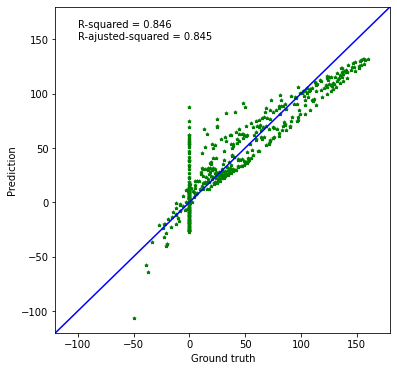

In [47]:
def r_plot(r_value, pred,test_y):
  # ax.set_aspect('equal', adjustable='box')
  # plt.figure(figsize=(6,6))
  fig, ax = plt.subplots(figsize=(6, 6))
  # ax.plot(test_y,test_y)
  ax.plot([0,1],[0,1],transform=ax.transAxes,c='blue')
  ax.scatter(test_y,pred,c="green",s=10,marker='*')
  ax.annotate("R-squared = {:.3f}\nR-ajusted-squared = {:.3f}".format(R_2,R_adj), (-100, 150))

  plt.xlim([-120, 180])
  plt.ylim([-120, 180])
  plt.xlabel('Ground truth')
  plt.ylabel('Prediction')
  
  plt.show()
r_plot(R_2, pred,test_y)

##(h) Plot your model’s predictions as a surface.

In [48]:
max_x =np.max(test_x,axis=0)
min_x =np.min(test_x,axis=0)
x1_before_mesh = np.linspace(min_x[0],max_x[0],100)
x2_before_mesh = np.linspace(min_x[1],max_x[1],100)
xx1,xx2 = np.meshgrid(x1_before_mesh,x2_before_mesh)
print(f"xx1.shape {xx1.shape}")
xx1_1 = xx1.reshape(-1,1)
xx2_1 = xx2.reshape(-1,1)
mesh_x = np.hstack((xx1_1,xx2_1))
_,mesh_std_x =standardization(train_x,test_x=mesh_x)
mesh_std_cubic_x = map_feature(mesh_std_x)
pred = mesh_std_cubic_x @ w
# plt.scatter(xx1_1,xx2_1,c=pred)

print(f"pred.shape {pred.shape}")

xx1.shape (100, 100)
u.shape (2,) std.shape (2,)
(10000, 10)
pred.shape (10000, 1)


In [49]:
print(f"xx1_1,xx2_1,pred {xx1_1.shape} {xx2_1.shape} {pred.shape}")

xx1_1,xx2_1,pred (10000, 1) (10000, 1) (10000, 1)


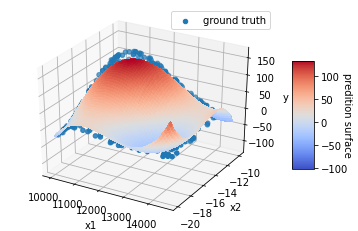

In [51]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(xx1,xx2,pred.reshape(xx1.shape), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.scatter(test_x[:,0].reshape(-1,1),test_x[:,1].reshape(-1,1),test_y.reshape(-1,1),label="ground truth")
ax.legend()
cbar =fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('predition surface', rotation=270)
ax.set(xlabel='x1',ylabel="x2",zlabel="y")
plt.show()


##Q3: K-Nearest Neighbors

##(a). k=1, output your model’s prediction

In [52]:
def distance(point,train_x,k=1):
  distance_lst = (np.sum((train_x-point)**2,axis=1))**(0.5)
  # print(((train_x-point)**2).shape)
  # print(distance_lst.shape)
  # lst = np.argpartition(distance_lst,k)[-k:]
  lst = (distance_lst).argsort()[:k]
  # print(lst)
  # print(np.argpartition(distance_lst, -k))
  # print()
  # print(lst)
  # print(np.argmin(distance_lst))
  # print(lst)
  # return np.argmin(distance_lst)
  return lst
def knn(test_x,train_x,train_y,k=1):

  n = len(test_x)
  ans_y =[]
  for i in range(n):
    # print(train_y[distance(test_x[i],train_x,k=k)])
    # print(np.mean(train_y[distance(test_x[i],train_x,k=k)]))
    ans_y.append(np.mean(train_y[distance(test_x[i],train_x,k=k)]))
    # break
  ans_y = np.array(ans_y).reshape(-1,1)
  return ans_y
# print()
pred = knn(test_x_std,train_x_std,train_y)
# distance([1,1],train_x)
# print(pred)  


In [53]:
print(f"prediction:\n {pred}")

prediction:
 [[ 46.654362  ]
 [  0.        ]
 [  7.1521917 ]
 [ 24.370017  ]
 [  0.        ]
 [ 33.337457  ]
 [144.52735   ]
 [ 15.109646  ]
 [153.40393   ]
 [  0.        ]
 [142.61515   ]
 [128.09012   ]
 [ 28.046865  ]
 [  0.        ]
 [ 51.508358  ]
 [ 76.380951  ]
 [  0.        ]
 [ 25.31819   ]
 [  0.        ]
 [ 95.682133  ]
 [ 93.081843  ]
 [ 68.97523   ]
 [ 74.780909  ]
 [-13.244251  ]
 [ 61.229556  ]
 [ 87.382913  ]
 [  0.        ]
 [  0.        ]
 [ 21.212106  ]
 [  0.        ]
 [131.09564   ]
 [ 38.130992  ]
 [ 54.611123  ]
 [ 59.511669  ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 69.438298  ]
 [-14.578794  ]
 [ 34.096713  ]
 [  0.        ]
 [ 22.536151  ]
 [  5.3627958 ]
 [ 54.611123  ]
 [136.75422   ]
 [ -4.8792703 ]
 [102.3278    ]
 [ 26.40769   ]
 [111.47157   ]
 [  0.        ]
 [  0.        ]
 [ 42.484169  ]
 [  0.        ]
 [ -6.8399453 ]
 [ 34.685646  ]
 [113.25884   ]
 [ 42.18141   ]
 [-23.569753  ]
 [  7.7651038 ]
 [ 99.77219

In [55]:
# rms = np.sqrt(np.mean((pred-test_y.reshape(-1,1))**2,axis=0))
# print(f"rms {rms}")

##(b). k=1, plot prediction and ground truth

In [56]:
pred = knn(mesh_std_x,train_x_std,train_y)
# print(f"prediction")

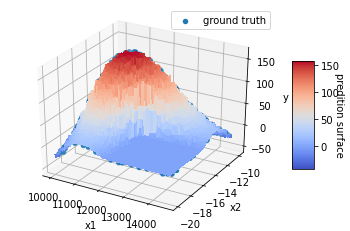

In [57]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(xx1,xx2,pred.reshape(xx1.shape), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.scatter(test_x[:,0].reshape(-1,1),test_x[:,1].reshape(-1,1),test_y.reshape(-1,1),label="ground truth")
ax.legend()
cbar =fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('predition surface', rotation=270)
ax.set(xlabel='x1',ylabel="x2",zlabel="y")
plt.show()


##(c). k=4 , output your model’s prediction

In [58]:
# print(test_x_std[:5])
# print(train_x_std[:5])
# print(train_y[:5])

In [59]:
pred = knn(test_x_std,train_x_std,train_y,k=4)
# distance([1,1],train_x)
print(pred) 

[[ 47.82520075]
 [  1.94127595]
 [  3.53349   ]
 [ 23.010314  ]
 [  0.        ]
 [ 33.16616875]
 [143.6071275 ]
 [ 17.25110925]
 [144.553385  ]
 [  0.        ]
 [139.317855  ]
 [122.1577575 ]
 [ 32.56594375]
 [  0.        ]
 [ 46.58921875]
 [ 76.93522625]
 [  0.        ]
 [ 25.6603695 ]
 [  0.        ]
 [100.38126775]
 [ 84.8478385 ]
 [ 81.60874825]
 [ 76.7378305 ]
 [-10.31073568]
 [ 65.5553395 ]
 [ 84.7474185 ]
 [  0.        ]
 [  0.        ]
 [ 18.20339375]
 [  0.        ]
 [129.913825  ]
 [ 34.7981695 ]
 [ 57.53032975]
 [ 56.48446725]
 [ 18.506154  ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  1.28746453]
 [ 75.71514075]
 [  5.1117646 ]
 [ 32.5441315 ]
 [  0.        ]
 [ 20.89536025]
 [  8.1929867 ]
 [ 57.53032975]
 [137.56297   ]
 [-10.05935588]
 [108.4501775 ]
 [ 22.79880075]
 [114.490785  ]
 [  0.        ]
 [  0.        ]
 [ 39.166985  ]
 [  0.        ]
 [-10.3120267 ]
 [ 37.338484  ]
 [118.212585  ]
 [ 46.2902115 ]
 [-16.71533475]
 [ 32.04212145]
 [104.35800725]
 [  0.  

##(b). k=4, plot prediction and ground truth

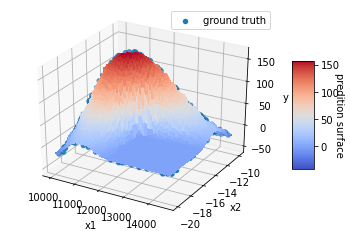

In [60]:
pred = knn(mesh_std_x,train_x_std,train_y,k=4)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(xx1,xx2,pred.reshape(xx1.shape), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.scatter(test_x[:,0].reshape(-1,1),test_x[:,1].reshape(-1,1),test_y.reshape(-1,1),label="ground truth")
ax.legend()
cbar =fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('predition surface', rotation=270)
ax.set(xlabel='x1',ylabel="x2",zlabel="y")
plt.show()


##(e) Note and report your qualitative observations about the differences between $K=1$ vs. $K=4$ regression.

From the two graph, we could notice that when $K=4$, the 3D plot is more smooth and seems natural, this is reasonable since it is using nearest 4 points and weights them to get the results. However, for the $K=1$ condition, only use one point will lead the prediction only has the out put of the train set, thus, the graph seems not smooth and natural than the $K=4$. 